In [1]:
import uproot
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import yahist
import itertools
import mplhep as hep

plt.rcParams.update({"figure.facecolor":  (1,1,1,0)})

from utils.analysis import Optimization

TAG = "kscans"

In [2]:
presort_babies = sorted(glob.glob(f"../analysis/studies/vbswh/output_{TAG}/Run2/*.root"))
presort_babies = [baby for baby in presort_babies if "data" not in baby]
presort_babies = [baby for baby in presort_babies if "Lambda" not in baby]
babies = []
for baby in sorted(presort_babies, reverse=True):
    if "EWK" in baby.split("/")[-1]:
        babies.append(baby)
    else:
        babies.insert(0, baby)
        
for baby_i, baby in enumerate(babies):
    if "VBSWH_SM" in baby.split("/")[-1] in baby:
        babies.append(babies.pop(baby_i))
        break
babies

['../analysis/studies/vbswh/output_kscans/Run2/Bosons.root',
 '../analysis/studies/vbswh/output_kscans/Run2/SingleTop.root',
 '../analysis/studies/vbswh/output_kscans/Run2/TTX.root',
 '../analysis/studies/vbswh/output_kscans/Run2/TTbar1L.root',
 '../analysis/studies/vbswh/output_kscans/Run2/TTbar2L.root',
 '../analysis/studies/vbswh/output_kscans/Run2/VBSWH_mkW.root',
 '../analysis/studies/vbswh/output_kscans/Run2/VH.root',
 '../analysis/studies/vbswh/output_kscans/Run2/WJets.root',
 '../analysis/studies/vbswh/output_kscans/Run2/EWKWLep.root',
 '../analysis/studies/vbswh/output_kscans/Run2/VBSWH_SM.root']

In [3]:
vbswh = Optimization(
    sig_root_files=[baby for baby in babies if "VBSWH_mkW" in baby],
    bkg_root_files=[baby for baby in babies if "VBSWH_mkW" not in baby and "VBSWH_SM" not in baby],
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", "lep_id_sf", "ewkfix_sf", 
        "elec_reco_sf", "muon_iso_sf", 
        "btag_sf", "pu_sf", "prefire_sf", "trig_sf"
    ],
    plots_dir=f"/home/users/jguiang/public_html/vbswh_plots/{TAG}/opt",
    sample_labels = {
#         "VBSWH_SM": "VBSWH (SM)", 
        "TTbar1L": r"$t\bar{t}+1\ell$",
        "TTbar2L": r"$t\bar{t}+2\ell$",
        "TTX": r"$t\bar{t}+X$",
        "SingleTop": "Single top",
        "WJets": "W+jets",
        "EWKWLep": r"EWK W$\rightarrow\ell\nu$"
    },
    reweight_column="reweights"
)
vbswh.df["presel_noVBS_noBVeto"] = vbswh.df.eval(
    "hbbjet_score > 0.3"
)
vbswh.df["presel_noVBS"] = vbswh.df.eval(
    "passes_bveto and hbbjet_score > 0.3"
)
vbswh.df["presel_noDetaJJ"] = vbswh.df.eval(
    "passes_bveto and M_jj > 500 and hbbjet_score > 0.3"
)
vbswh.df["presel"] = vbswh.df.eval(
    "passes_bveto and M_jj > 500 and abs(deta_jj) > 3 and hbbjet_score > 0.3"
)
# vbswh.df["SR"] = vbswh.df.eval(
#     "presel and ST > 1200 and M_jj > 1500 and abs(deta_jj) > 4 and hbbjet_score > 0.9 and hbbjet_msoftdrop < 150"
# )
vbswh.df["SR2"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 1500 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop < 150"
)
vbswh.df["regionA"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop >= 150"
)
vbswh.df["regionB"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) <= 4 and hbbjet_msoftdrop >= 150"
)
vbswh.df["regionC"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) <= 4 and hbbjet_msoftdrop < 150"
)
vbswh.df["SR1"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop < 150"
)
# vbswh.make_selection("passes_bveto == True")
# vbswh.make_selection("passes_bveto != True")

Loading bkg babies: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:36<00:00,  4.55s/it]


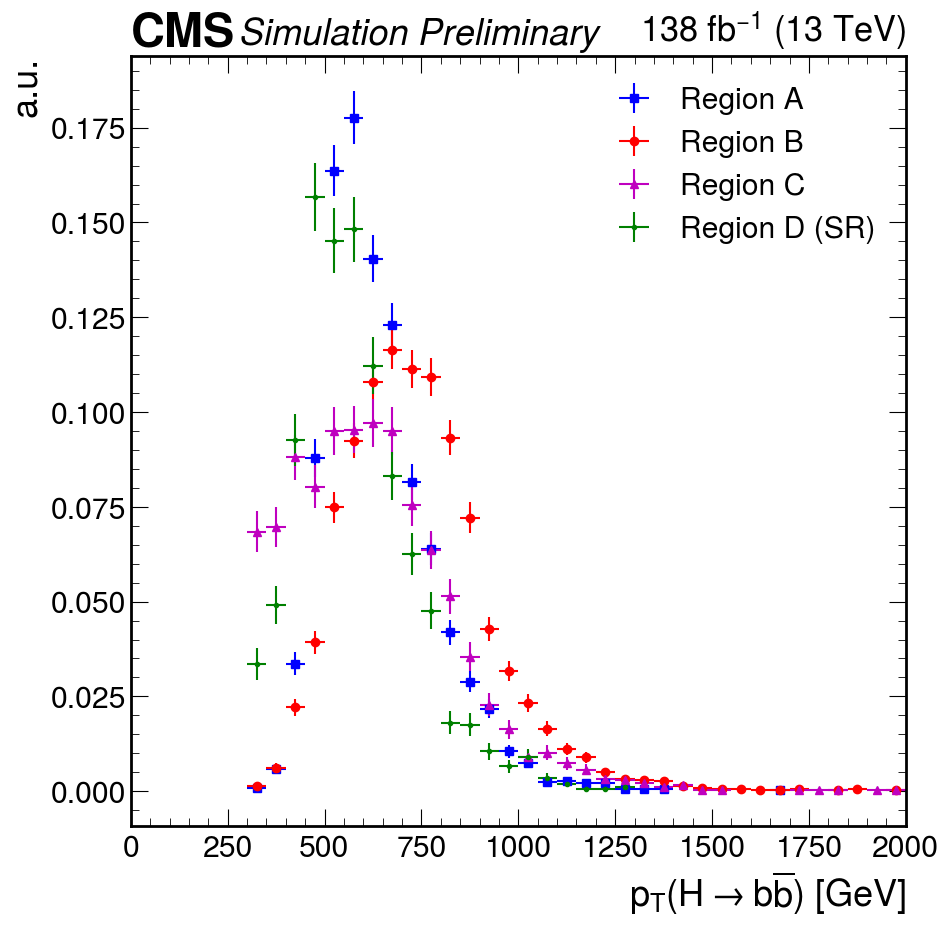

In [4]:
bins = np.linspace(0, 2000, 41)

fig, axes = plt.subplots()

ttbar_df = vbswh.bkg_df(selection="name == 'TTbar1L' or name == 'TTbar2L'")

regionA_hist = yahist.Hist1D(
    ttbar_df[ttbar_df.regionA].hbbjet_pt.values,
    bins=bins,
    color="b",
    label="Region A"
).normalize()
regionA_hist.plot(ax=axes, errors=True, fmt="s")

regionB_hist = yahist.Hist1D(
    ttbar_df[ttbar_df.regionB].hbbjet_pt.values,
    bins=bins,
    color="r",
    label="Region B"
).normalize()
regionB_hist.plot(ax=axes, errors=True, fmt="o")

regionC_hist = yahist.Hist1D(
    ttbar_df[ttbar_df.regionC].hbbjet_pt.values,
    bins=bins,
    color="m",
    label="Region C"
).normalize()
regionC_hist.plot(ax=axes, errors=True, fmt="^")

regionD_hist = yahist.Hist1D(
    ttbar_df[ttbar_df.SR1].hbbjet_pt.values,
    bins=bins,
    color="g",
    label="Region D (SR)"
).normalize()
regionD_hist.plot(ax=axes, errors=True, fmt=".")

hep.cms.label("Preliminary", data=False, lumi=138, loc=0, ax=axes)

axes.set_ylabel("a.u.");
axes.set_xlabel(r"$p_T(H\rightarrow b\overline{b})$ [GeV]");

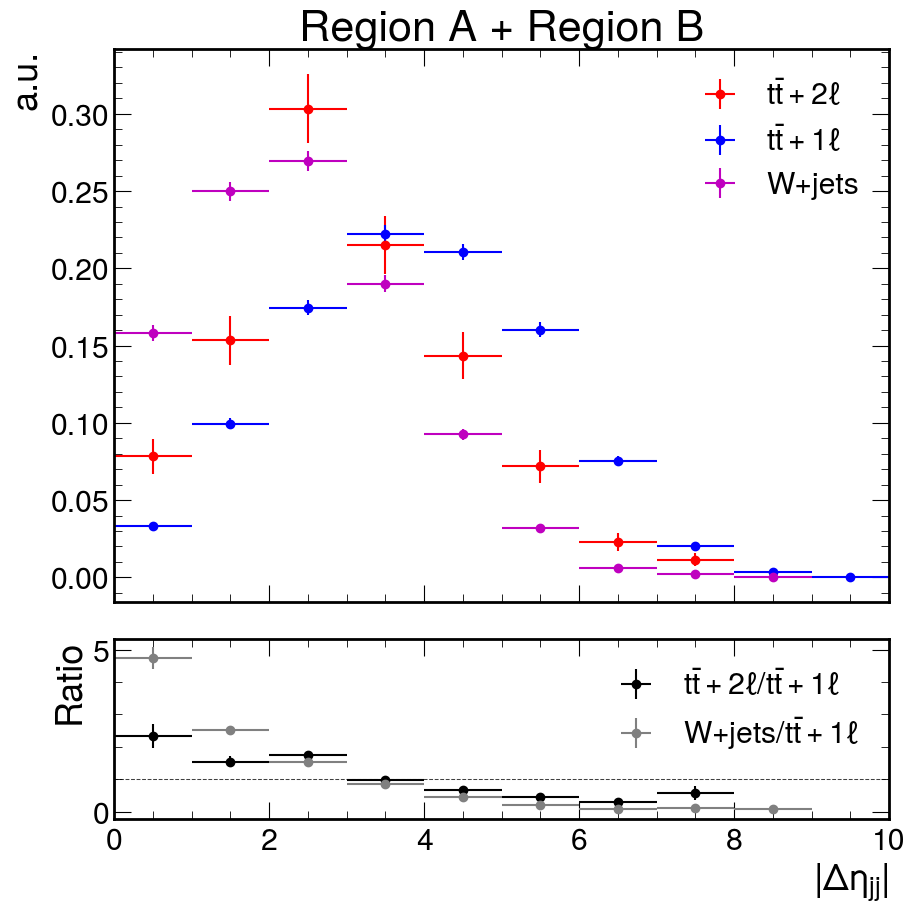

In [5]:
selection = "(regionA or regionB)"
bins = np.linspace(0, 10, 11)

fig = plt.figure()
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.1)
hist_axes = fig.add_subplot(gs[0])
ratio_axes = fig.add_subplot(gs[1])


tt1l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar1L'")
tt2l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar2L'")
wjets_df = vbswh.bkg_df(selection=f"{selection} and name == 'WJets'")

tt1l_hist = yahist.Hist1D(
    np.abs(tt1l_df.deta_jj.values),
    bins=bins,
    color="b",
    label=r"$t\bar{t}+1\ell$"
).normalize()
tt2l_hist = yahist.Hist1D(
    np.abs(tt2l_df.deta_jj.values),
    bins=bins,
    color="r",
    label=r"$t\bar{t}+2\ell$"
).normalize()
wjets_hist = yahist.Hist1D(
    np.abs(wjets_df.deta_jj.values),
    bins=bins,
    color="m",
    label="W+jets"
).normalize()
ratio_hist = tt1l_hist/tt2l_hist

tt2l_hist.plot(ax=hist_axes, errors=True)
tt1l_hist.plot(ax=hist_axes, errors=True)
wjets_hist.plot(ax=hist_axes, errors=True)
(tt2l_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="k", label=r"$t\bar{t}+2\ell/t\bar{t}+1\ell$")
(wjets_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="grey", label=r"W+jets$/t\bar{t}+1\ell$")

hist_axes.set_xticklabels([]);
hist_axes.set_ylabel("a.u.")
hist_axes.set_title("Region A + Region B");

ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
# ratio_axes.legend().remove()
ratio_axes.set_ylabel("Ratio");
ratio_axes.set_xlabel(r"$|\Delta\eta_{jj}|$");

plot_file = f"/home/users/jguiang/public_html/vbswh_plots/{TAG}/opt/AB_wjets_vs_ttbar.pdf"
plt.savefig(plot_file, bbox_inches="tight")

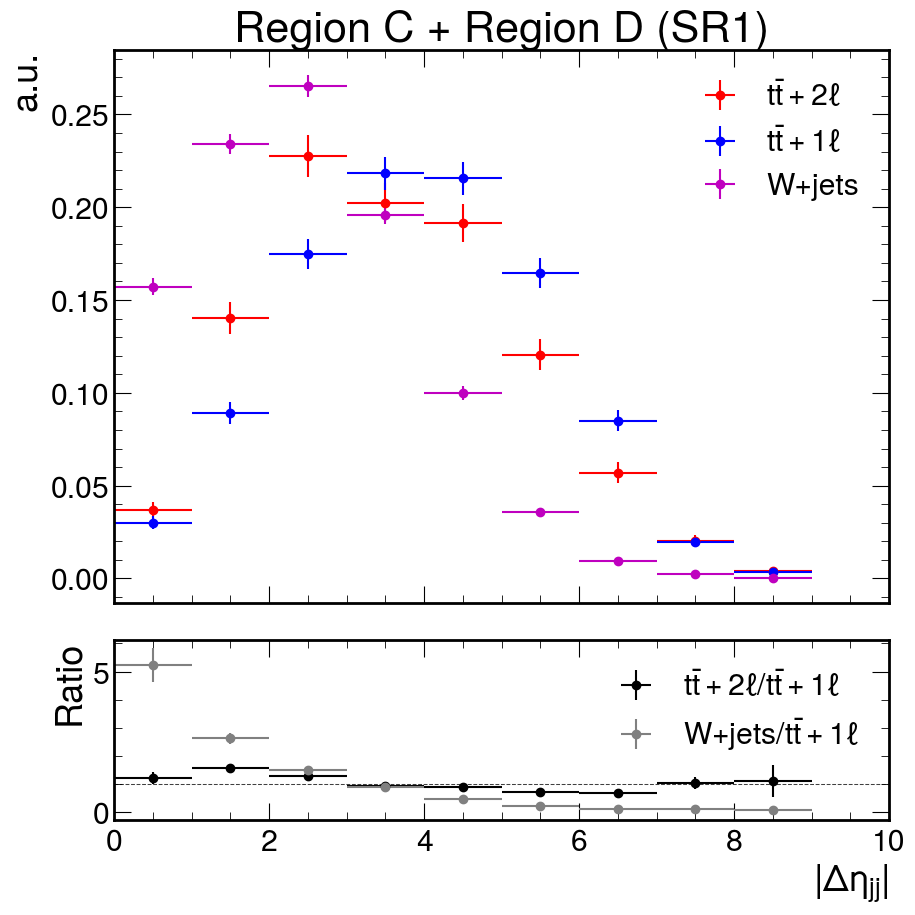

In [6]:
selection = "(regionC or SR1)"
bins = np.linspace(0, 10, 11)

fig = plt.figure()
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.1)
hist_axes = fig.add_subplot(gs[0])
ratio_axes = fig.add_subplot(gs[1])


tt1l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar1L'")
tt2l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar2L'")
wjets_df = vbswh.bkg_df(selection=f"{selection} and name == 'WJets'")

tt1l_hist = yahist.Hist1D(
    np.abs(tt1l_df.deta_jj.values),
    bins=bins,
    color="b",
    label=r"$t\bar{t}+1\ell$"
).normalize()
tt2l_hist = yahist.Hist1D(
    np.abs(tt2l_df.deta_jj.values),
    bins=bins,
    color="r",
    label=r"$t\bar{t}+2\ell$"
).normalize()
wjets_hist = yahist.Hist1D(
    np.abs(wjets_df.deta_jj.values),
    bins=bins,
    color="m",
    label="W+jets"
).normalize()
ratio_hist = tt1l_hist/tt2l_hist

tt2l_hist.plot(ax=hist_axes, errors=True)
tt1l_hist.plot(ax=hist_axes, errors=True)
wjets_hist.plot(ax=hist_axes, errors=True)
(tt2l_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="k", label=r"$t\bar{t}+2\ell/t\bar{t}+1\ell$")
(wjets_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="grey", label=r"W+jets$/t\bar{t}+1\ell$")

hist_axes.set_xticklabels([]);
hist_axes.set_ylabel("a.u.")
hist_axes.set_title("Region C + Region D (SR1)");

ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
# ratio_axes.legend().remove()
ratio_axes.set_ylabel("Ratio");
ratio_axes.set_xlabel(r"$|\Delta\eta_{jj}|$");

plot_file = f"/home/users/jguiang/public_html/vbswh_plots/{TAG}/opt/CD_wjets_vs_ttbar.pdf"
plt.savefig(plot_file, bbox_inches="tight")

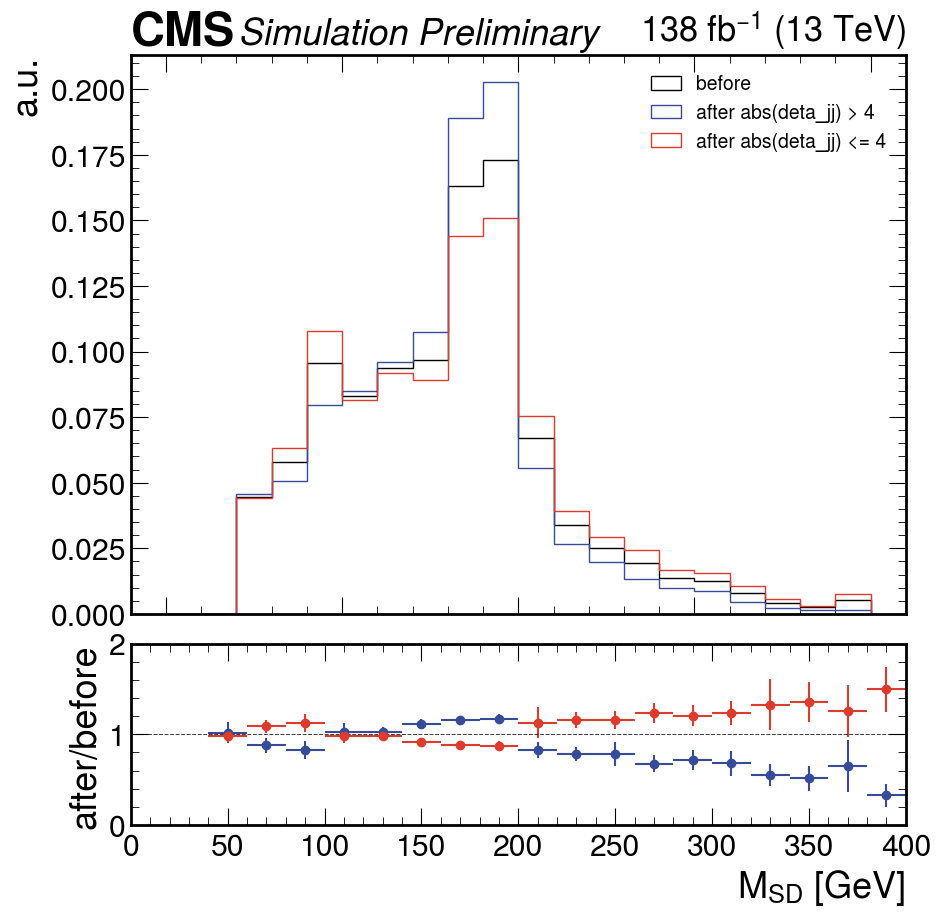

In [7]:
vbswh.plot_correlation(
    "hbbjet_msoftdrop", 
    np.linspace(0, 400, 21), 
    selections=[
        "abs(deta_jj) > 4",
        "abs(deta_jj) <= 4"
    ],
    base_selection="presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9",
    x_label="$M_{SD}$ [GeV]",
);

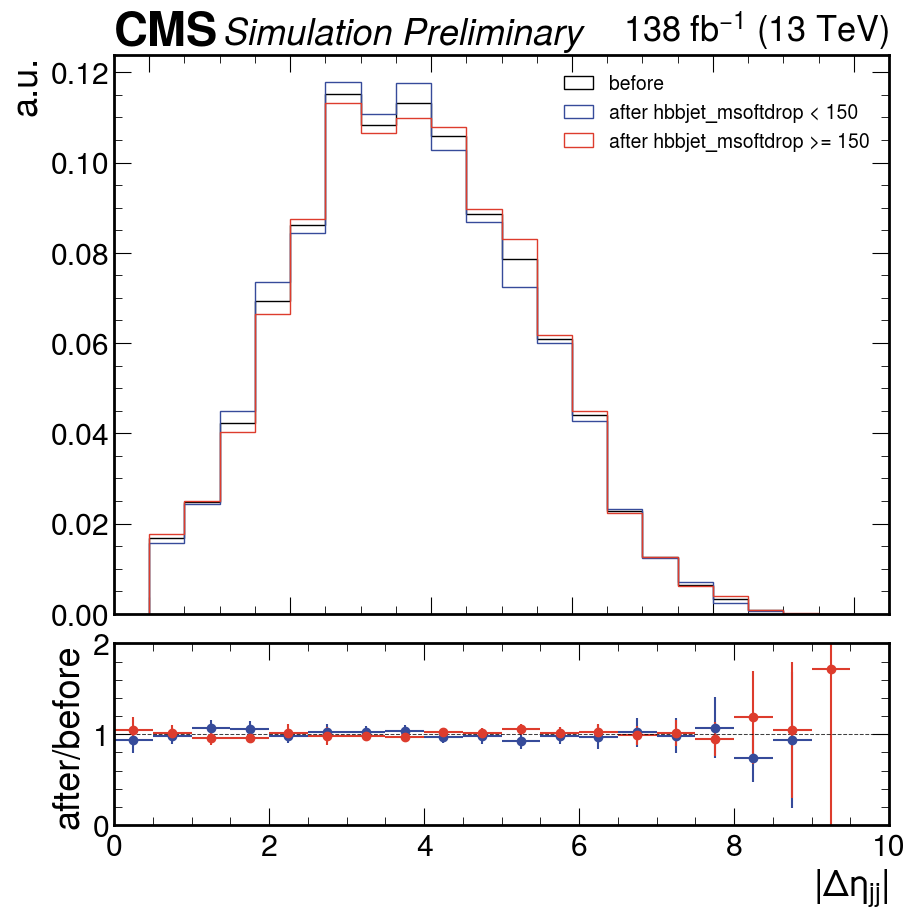

In [8]:
vbswh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 21),  
    selections=[
        "hbbjet_msoftdrop < 150",
        "hbbjet_msoftdrop >= 150"
    ], 
    base_selection="presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

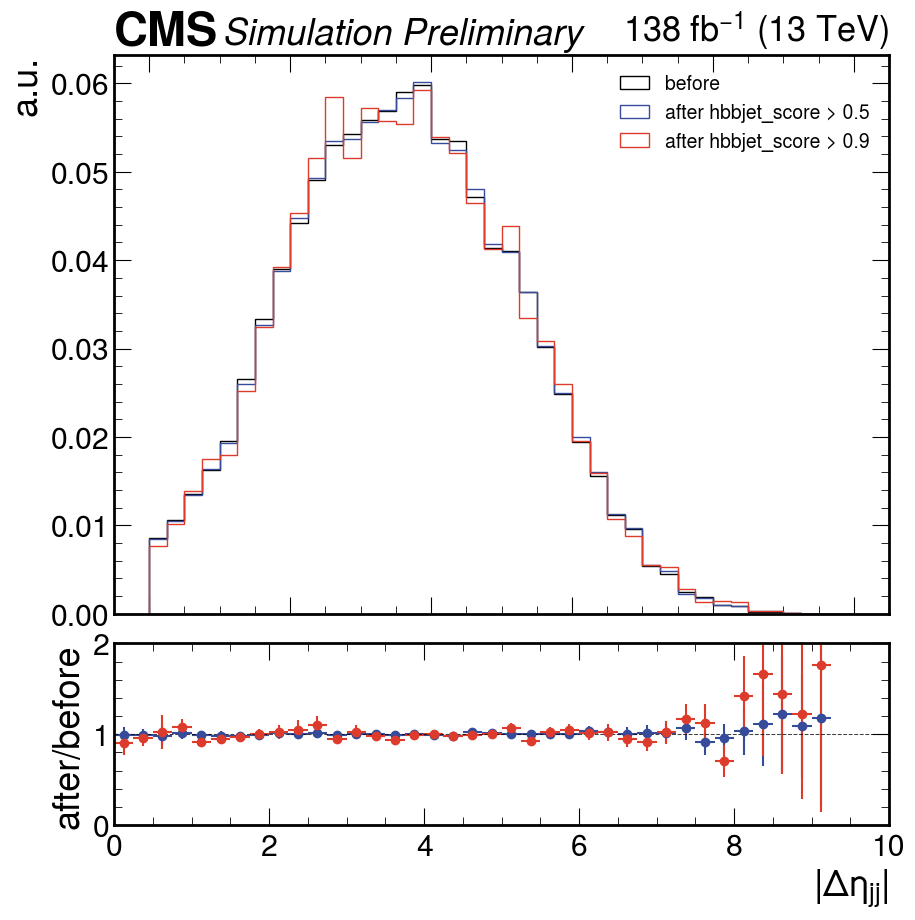

In [9]:
vbswh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 41),  
    selections=[
        "hbbjet_score > 0.5",
        "hbbjet_score > 0.9"
    ], 
    base_selection="presel_noDetaJJ and hbbjet_msoftdrop >= 150",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

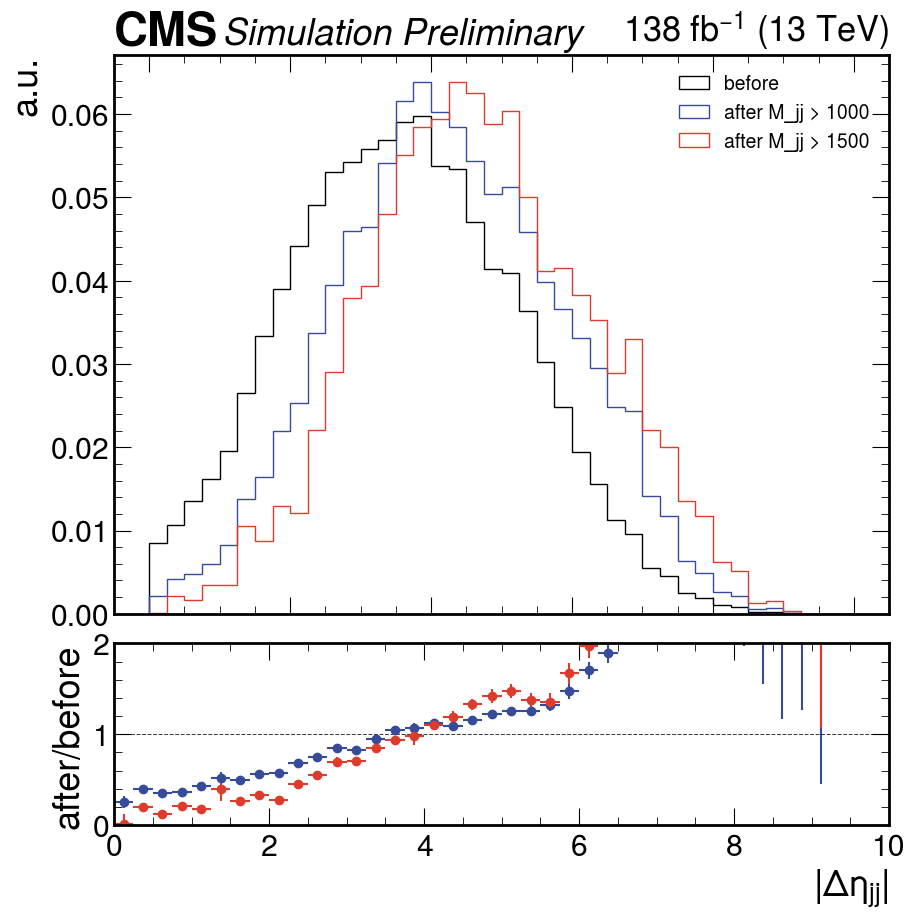

In [10]:
vbswh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 41),  
    selections=[
        "M_jj > 1000",
        "M_jj > 1500"
    ], 
    base_selection="presel_noDetaJJ and hbbjet_msoftdrop >= 150",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

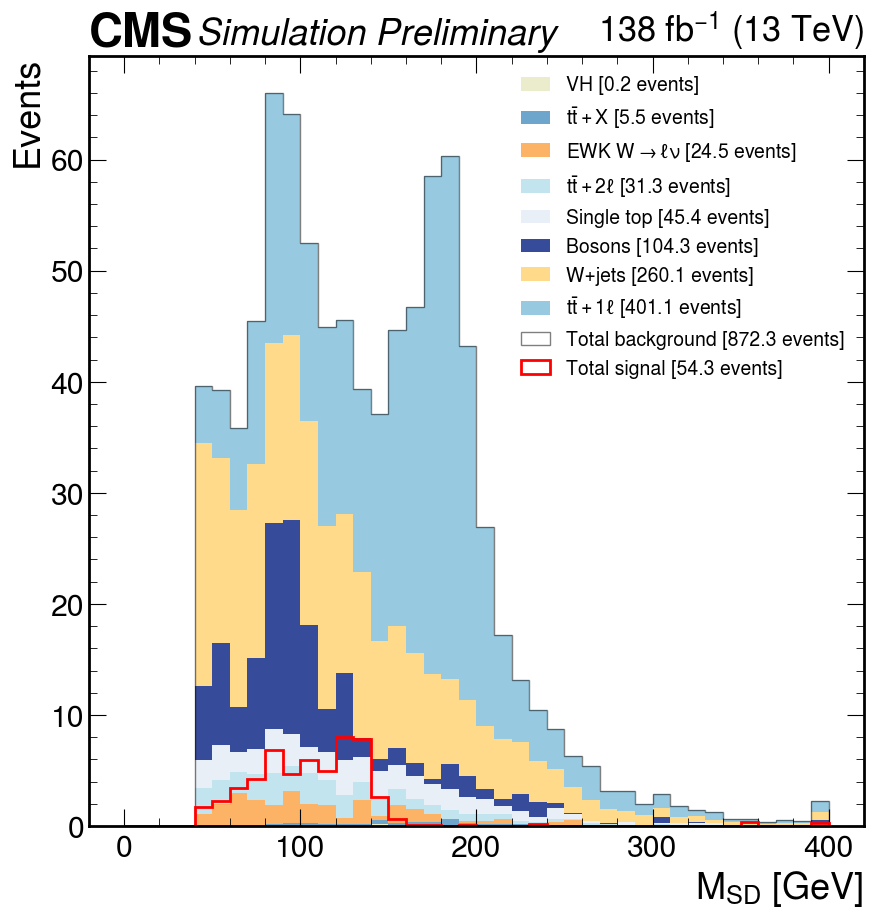

In [11]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_msoftdrop", np.linspace(0, 400, 41), 
    selection="presel and hbbjet_score < 0.6",
    x_label="$M_{SD}$ [GeV]",
    stacked=True,
#     norm=True
);

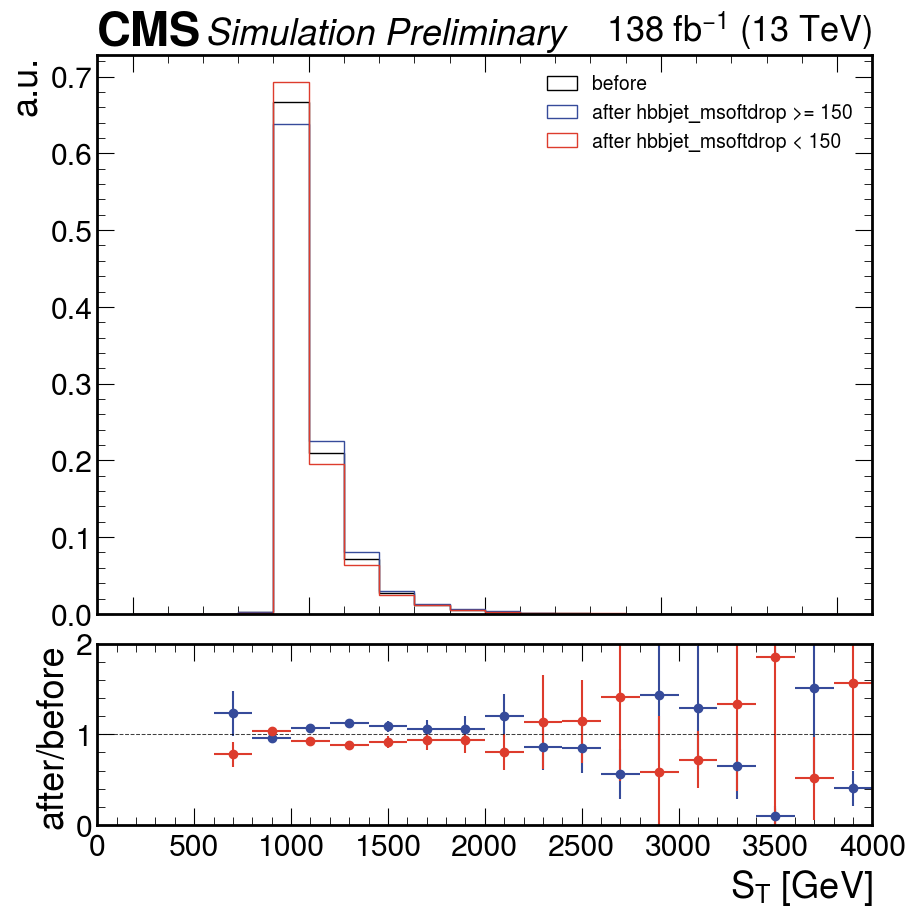

In [12]:
vbswh.plot_correlation(
    "ST", 
    np.linspace(0, 4000, 21),  
    selections=[
        "hbbjet_msoftdrop >= 150",
        "hbbjet_msoftdrop < 150"
    ], 
    base_selection="presel",
    x_label=r"$S_T$ [GeV]"
);

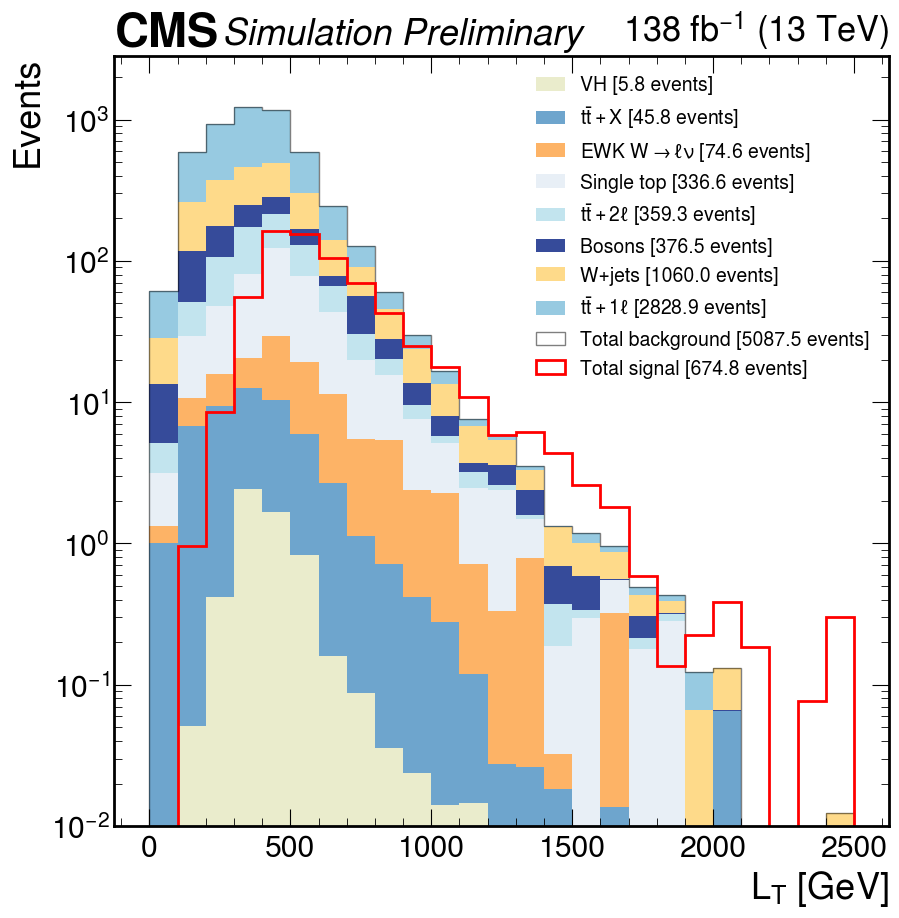

In [13]:
axes = vbswh.plot_sig_vs_bkg(
    "LT", np.linspace(0, 2500, 26), 
    selection="presel_noDetaJJ",
    x_label="$L_T$ [GeV]",
    stacked=True,
    logy=True
);

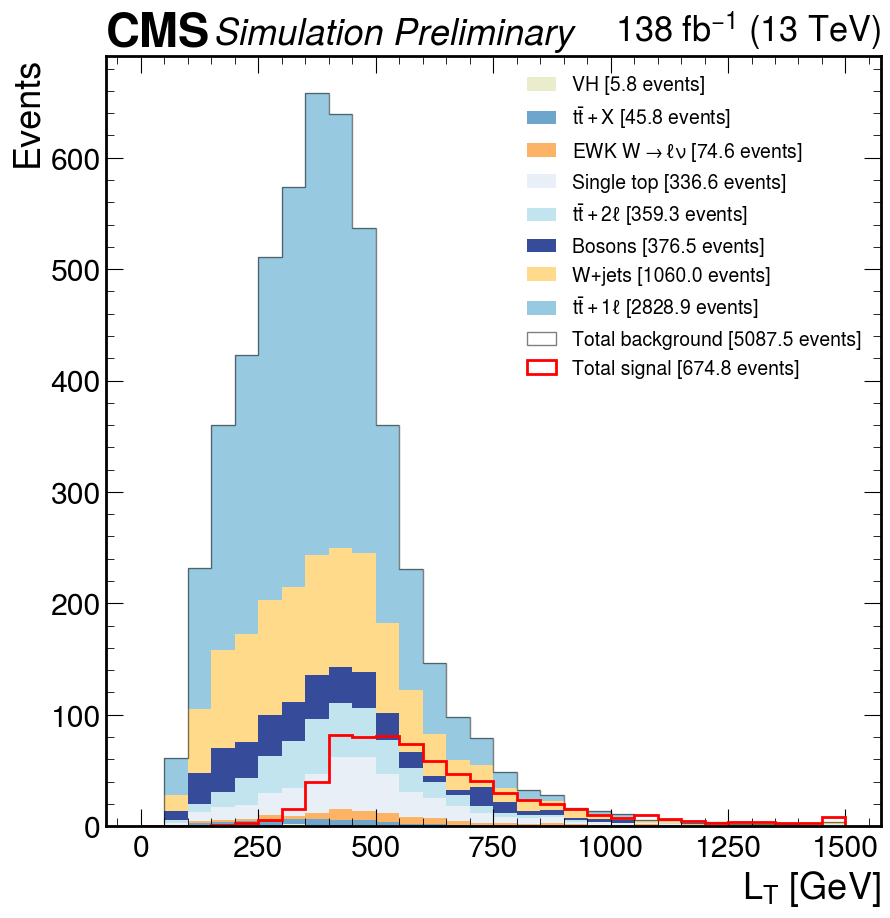

In [14]:
axes = vbswh.plot_sig_vs_bkg(
    "LT", np.linspace(0, 1500, 31), 
    selection="presel_noDetaJJ",
    x_label="$L_T$ [GeV]",
    stacked=True,
#     norm=True
);

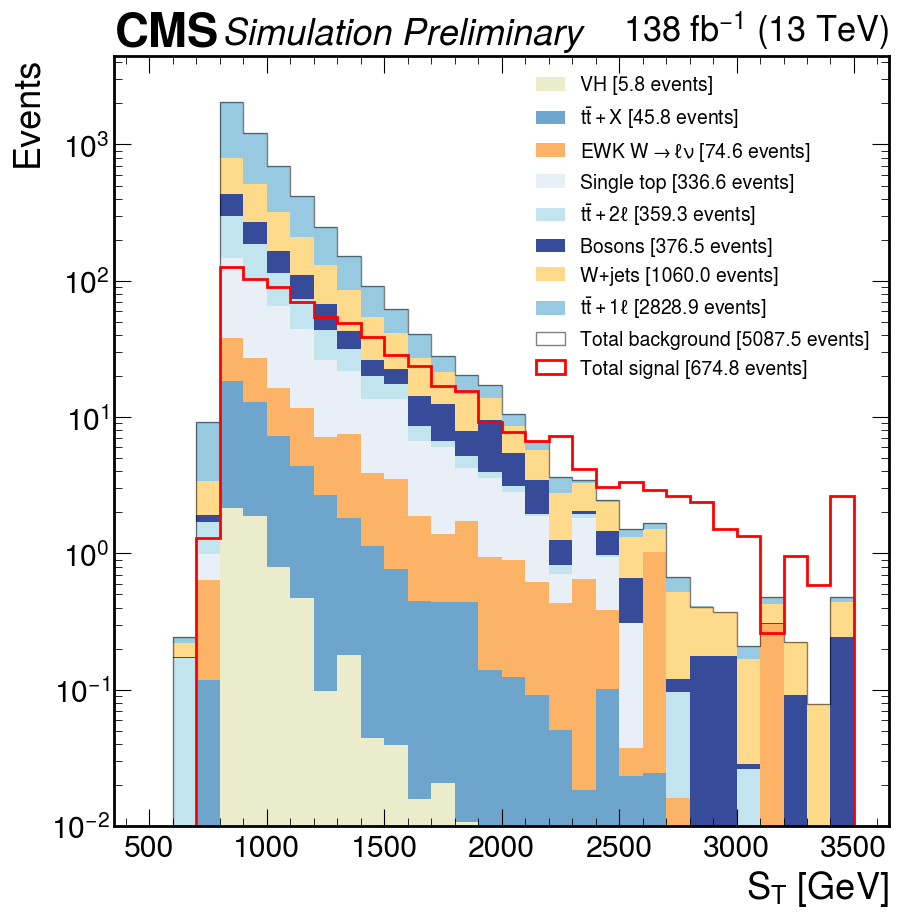

In [15]:
axes = vbswh.plot_sig_vs_bkg(
    "ST", np.linspace(500, 3500, 31), 
    selection="presel_noDetaJJ",
    x_label="$S_T$ [GeV]",
    stacked=True,
    logy=True
);

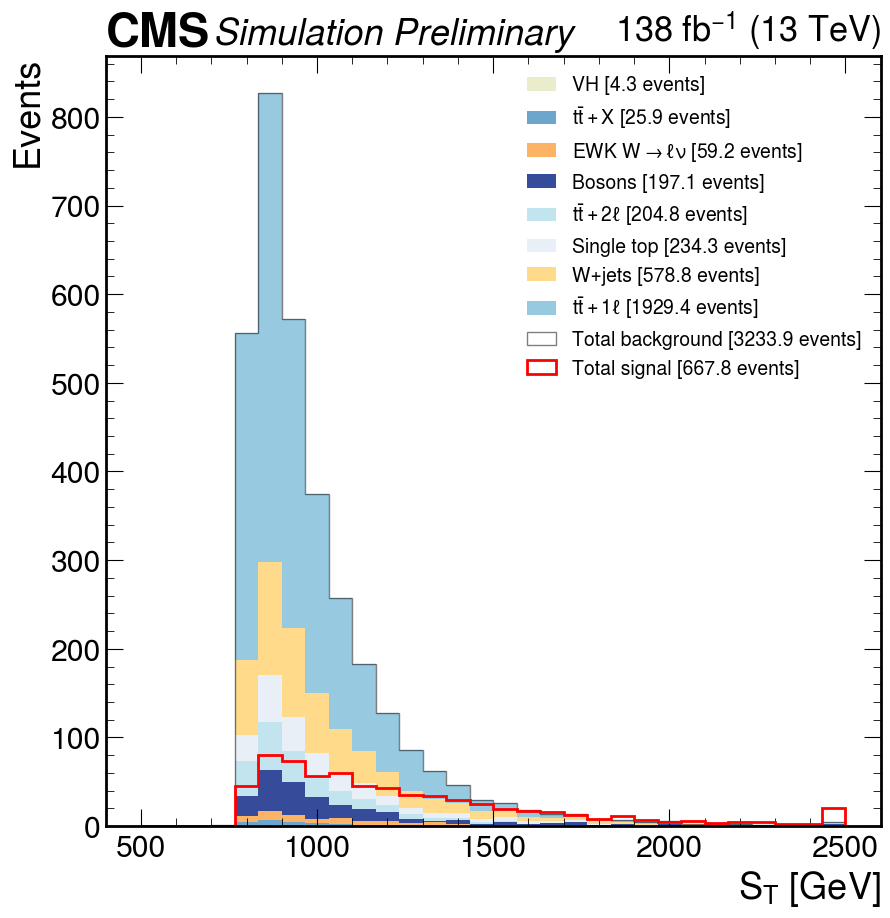

In [16]:
axes = vbswh.plot_sig_vs_bkg(
    "ST", np.linspace(500, 2500, 31), 
    selection="presel",
    x_label="$S_T$ [GeV]",
    stacked=True,
#     logy=True,
#     norm=True
);

In [17]:
vbswh.get_event_counts(selection="presel and hbbjet_msoftdrop >= 150")

(20.432747735475257, 1575.9464806359367)

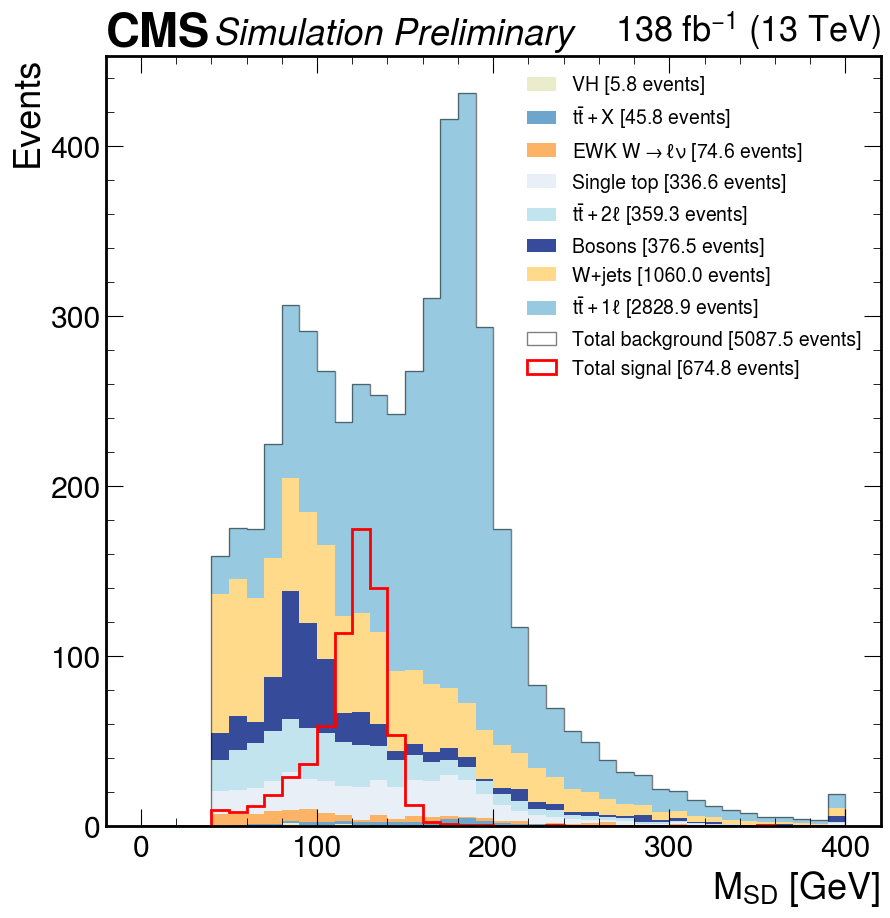

In [18]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_msoftdrop", np.linspace(0, 400, 41), 
    selection="presel_noDetaJJ",
    x_label="$M_{SD}$ [GeV]",
    stacked=True,
#     norm=True
);

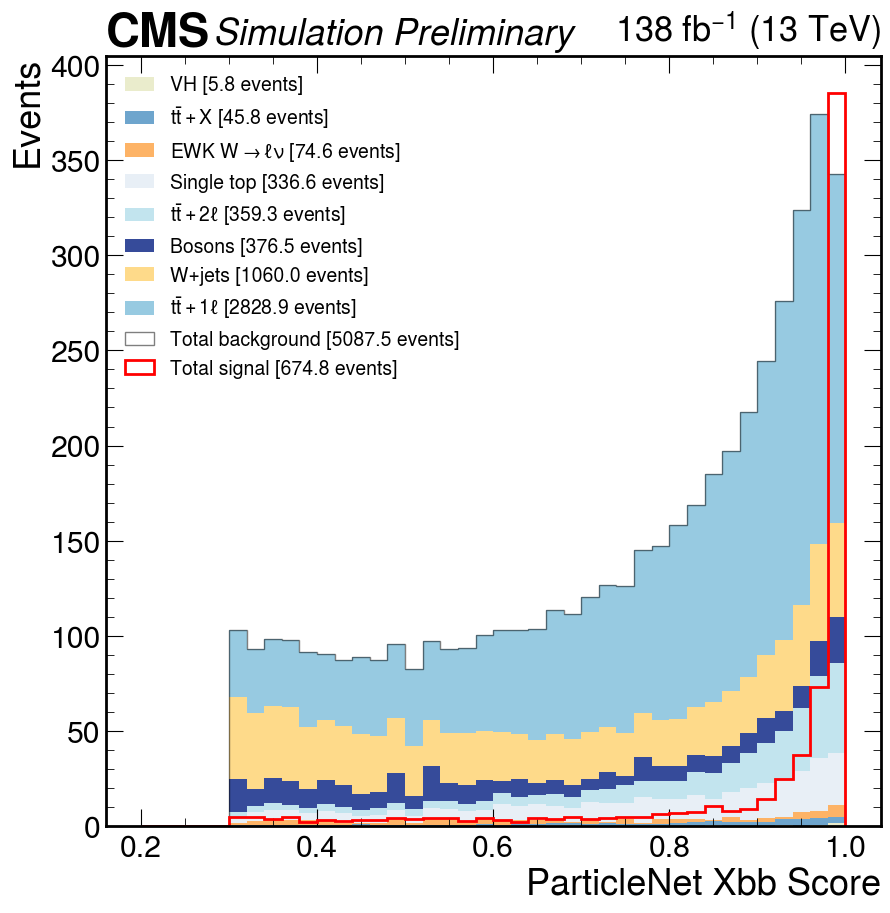

In [19]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_score", np.linspace(0.2, 1, 41), 
    selection="presel_noDetaJJ",
    x_label="ParticleNet Xbb Score",
    stacked=True,
    legend_loc="upper left"
#     norm=True
);

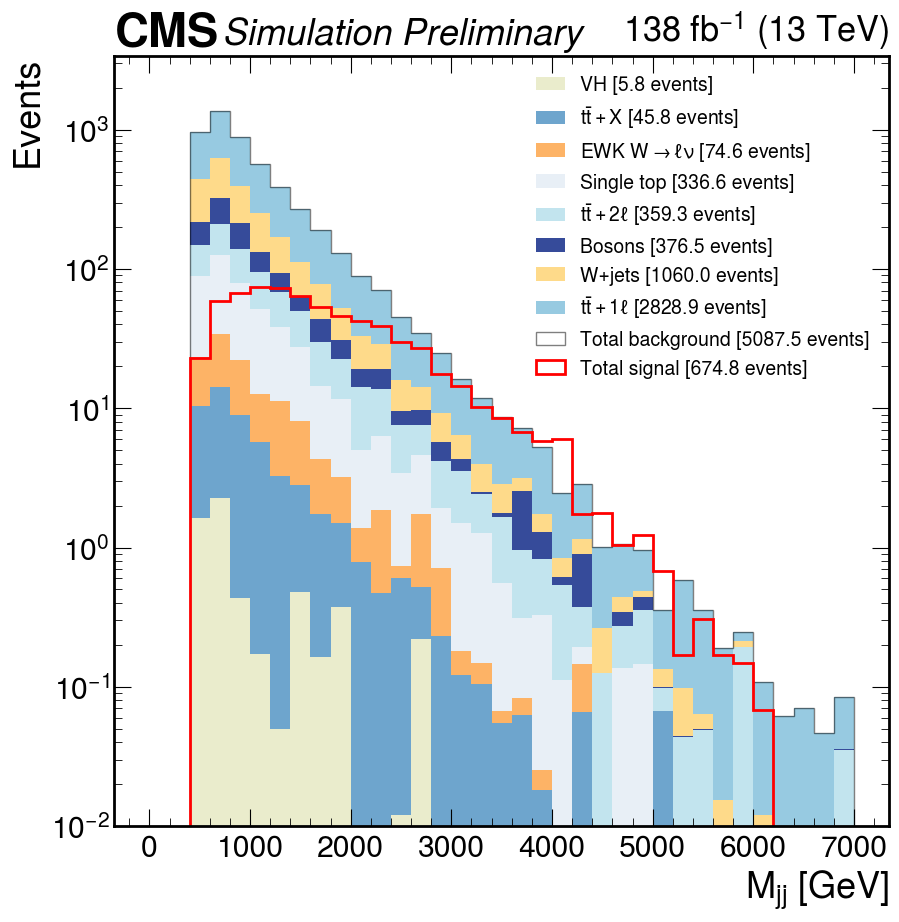

In [20]:
axes = vbswh.plot_sig_vs_bkg(
    "M_jj", np.linspace(0, 7000, 36), 
    selection="presel_noDetaJJ",
    x_label="$M_{jj}$ [GeV]",
    stacked=True,
    logy=True
);

In [21]:
vbswh.get_event_counts(selection="presel_noDetaJJ and abs(deta_jj) <= 3")

(6.94746048205867, 1853.5534206432997)

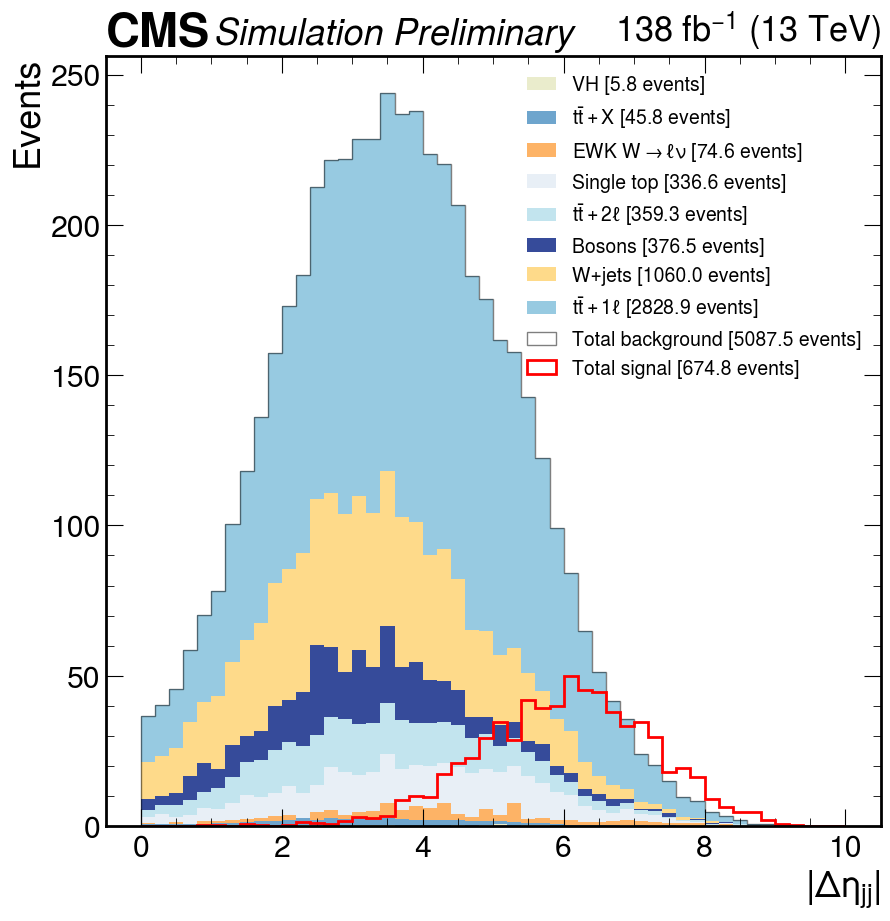

In [22]:
axes = vbswh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(0, 10, 51), 
    selection="presel_noDetaJJ", 
    x_label="$|\Delta\eta_{jj}|$",
    transf=abs,
    stacked=True
);

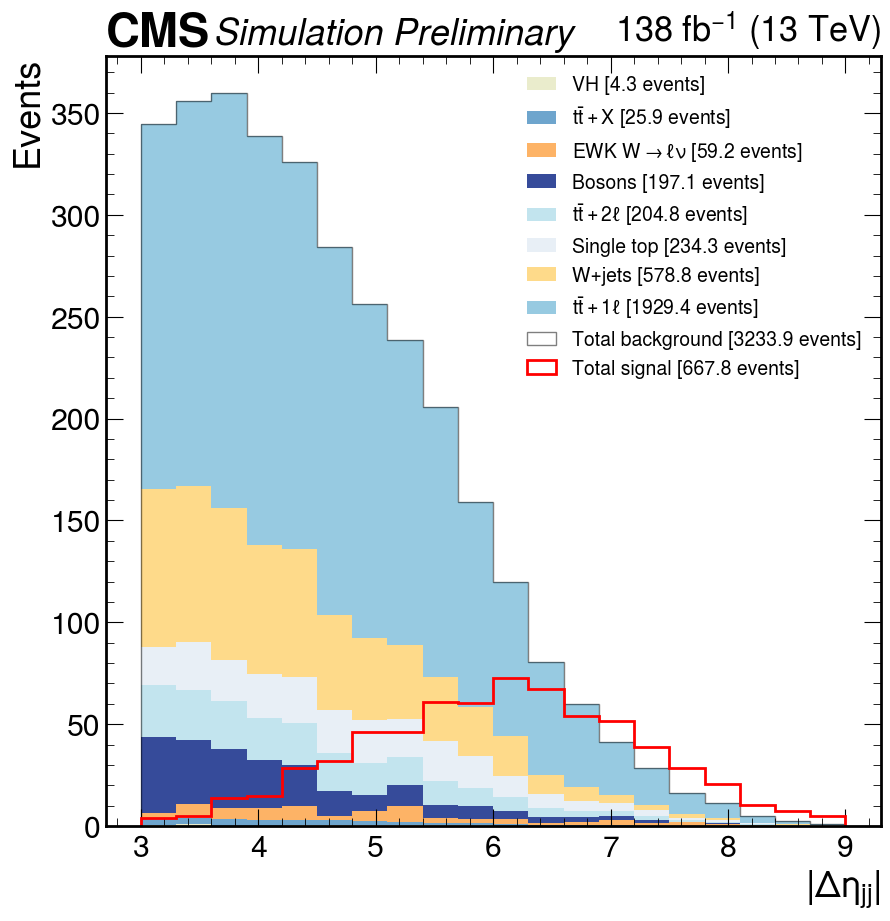

In [23]:
axes = vbswh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(3, 9, 21), 
    selection="presel", 
    x_label="$|\Delta\eta_{jj}|$",
    transf=abs,
    stacked=True
);

In [24]:
vbswh.fom_scan(
    "deta_jj", [3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7], operator=">", 
    base_selection="M_jj > 1500", abs=True
)

sel,sig,bkg,fom
M_jj > 1500,553.0517535955828,5283.773263891005,7.608406137141962
M_jj > 1500 and abs(deta_jj) > 3.5,551.2106071657494,4125.531335861041,8.581784827334367
M_jj > 1500 and abs(deta_jj) > 4,547.0486111506306,3611.3838752559236,9.103095365265585
M_jj > 1500 and abs(deta_jj) > 4.5,540.2648882921065,3001.464402813317,9.861435652812743
M_jj > 1500 and abs(deta_jj) > 5,519.5076655464976,2317.645346008786,10.791168411849851
M_jj > 1500 and abs(deta_jj) > 5.5,488.03936645041676,1690.5733805275731,11.869648042350235
M_jj > 1500 and abs(deta_jj) > 6,423.71327717213535,1177.006263958588,12.350447272199693
M_jj > 1500 and abs(deta_jj) > 6.5,318.192091204461,786.1824077353363,11.348219309554617
M_jj > 1500 and abs(deta_jj) > 7,214.5404016523658,469.49460018586365,9.901335773285924


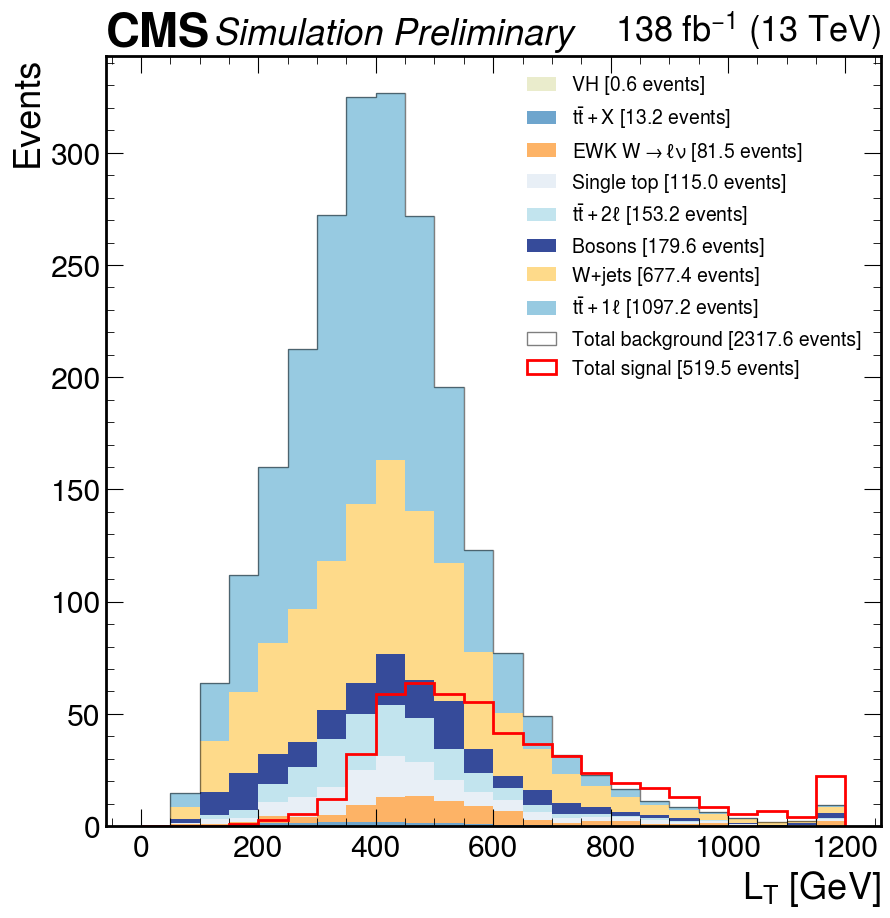

In [25]:
vbswh.plot_sig_vs_bkg(
    "LT", np.linspace(0, 1200, 25), 
    selection="M_jj > 1500 and abs(deta_jj) > 5", 
    x_label="$L_T$ [GeV]",
    stacked=True
);

In [26]:
vbswh.fom_scan(
    "LT", [500, 600, 700, 800, 900, 1000, 1100, 1200], operator=">", 
    base_selection="M_jj > 1500 and abs(deta_jj) > 5"
);

sel,sig,bkg,fom
M_jj > 1500 and abs(deta_jj) > 5,519.5076655464976,2317.645346008786,10.791168411849851
M_jj > 1500 and abs(deta_jj) > 5 and LT > 500,343.5724920827351,558.9480680391576,14.532243135910855
M_jj > 1500 and abs(deta_jj) > 5 and LT > 600,229.0237758211982,240.2902720737501,14.774489232194318
M_jj > 1500 and abs(deta_jj) > 5 and LT > 700,150.99983580772775,113.93122499327868,14.14669829816587
M_jj > 1500 and abs(deta_jj) > 5 and LT > 800,96.36963625586417,59.39263325075176,12.504718783312573
M_jj > 1500 and abs(deta_jj) > 5 and LT > 900,60.25326117900875,31.867659279057847,10.673466105554784
M_jj > 1500 and abs(deta_jj) > 5 and LT > 1000,38.644887859823626,17.345675838968454,9.27889880663086
M_jj > 1500 and abs(deta_jj) > 5 and LT > 1100,26.342434182513806,11.702635486236339,7.700413818856894
M_jj > 1500 and abs(deta_jj) > 5 and LT > 1200,18.48847507360013,7.393323875761645,6.799566512161854


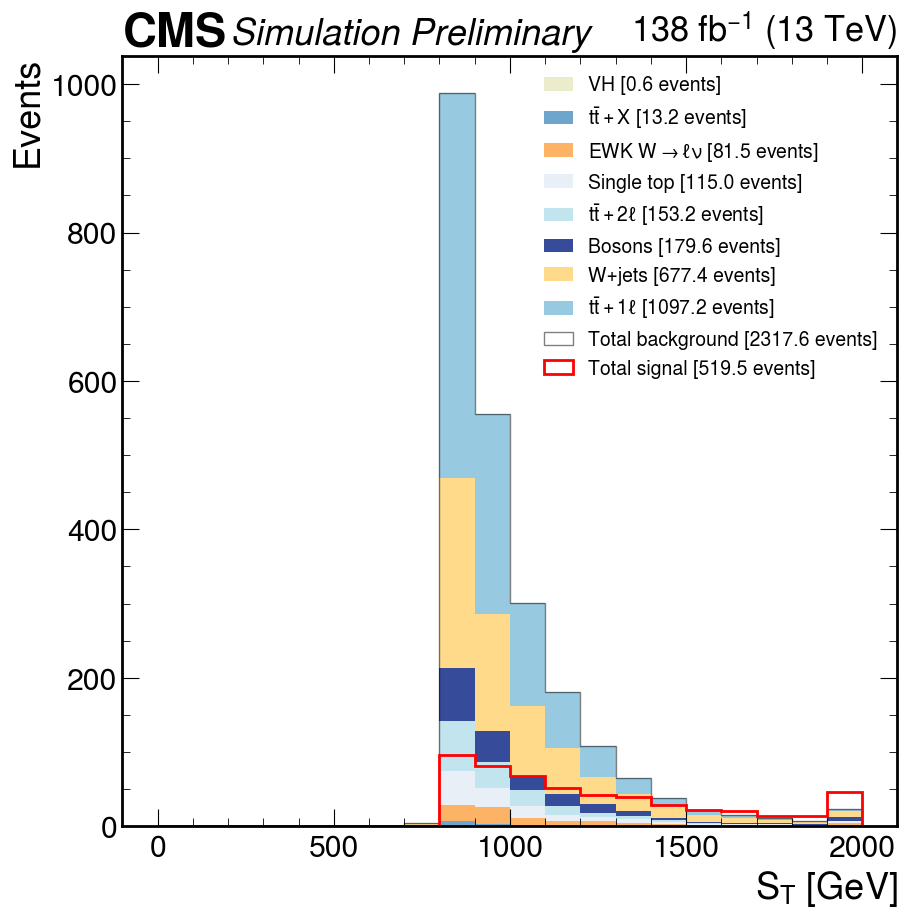

In [27]:
axes = vbswh.plot_sig_vs_bkg(
    "ST", np.linspace(0, 2000, 21), 
    selection="M_jj > 1500 and abs(deta_jj) > 5", x_label="$S_T$ [GeV]",
    stacked=True
);

In [28]:
vbswh.fom_scan(
    "ST", [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1650, 1700, 1800], operator=">", 
    base_selection="M_jj > 1500 and abs(deta_jj) > 5"
)

sel,sig,bkg,fom
M_jj > 1500 and abs(deta_jj) > 5,519.5076655464976,2317.645346008786,10.791168411849851
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1000,342.0467320808327,769.7621828273236,12.328412580501611
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1100,275.1305993577184,469.3267397850912,12.699927592755646
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1200,224.41000253992755,288.0283895579397,13.222834510075725
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300,182.33892261289193,179.98975756144773,13.591127553186583
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1400,143.30716301421648,115.40508040496721,13.339987867730947
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1500,114.33278775504846,77.69420758572558,12.971089983147628
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1600,92.39464784905911,55.78480200642022,12.370545942795887
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1650,81.77030532719034,47.7539699240822,11.832891398633357
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1700,71.8581119296591,40.60925050

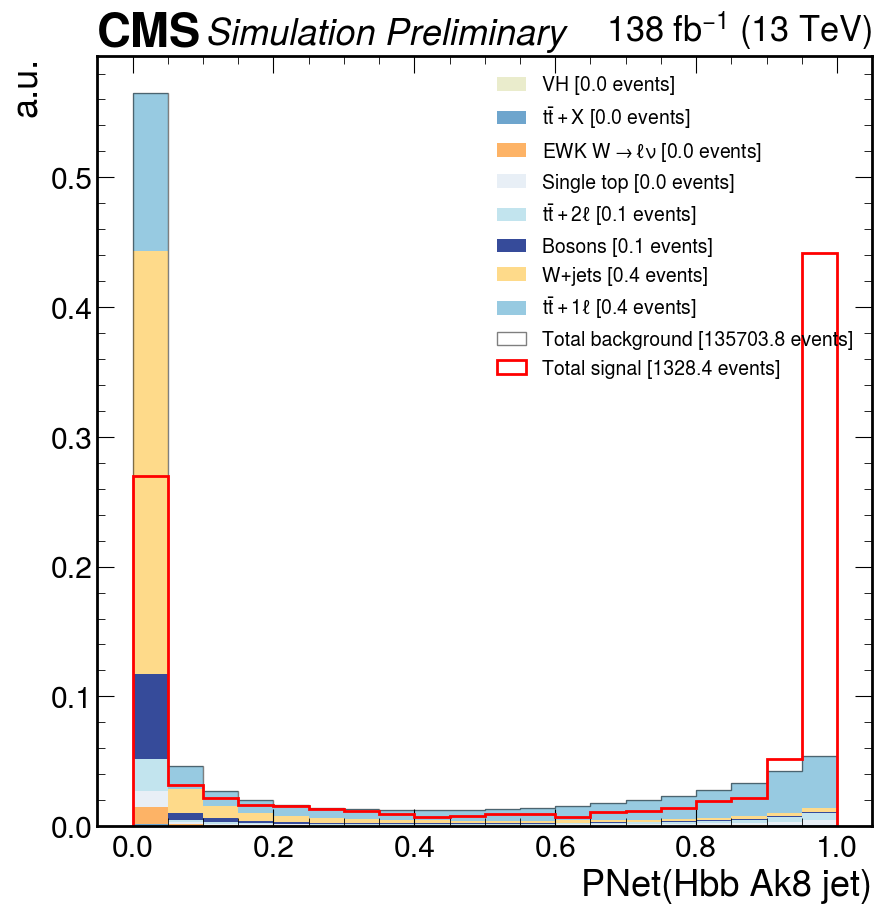

In [29]:
vbswh.plot_sig_vs_bkg(
    "hbbjet_score", np.linspace(0, 1.0, 21), 
#     selection="M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300", 
    x_label="PNet(Hbb Ak8 jet)",
    stacked=True,
    norm=True
);

In [30]:
vbswh.fom_scan(
    "hbbjet_score", np.linspace(0.91, 0.99, 9), operator=">", 
    base_selection="M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300"
)

sel,sig,bkg,fom
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300,182.33892261289193,179.98975756144773,13.591127553186583
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.91,95.39355973239648,14.617441102647994,24.950737034380456
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.92,94.22147897306732,13.07475664345499,26.05752180556178
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.93,92.10764210234203,11.868446565527034,26.736141150266782
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.9400000000000001,90.3960004366626,10.700300042008157,27.63447623839232
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.95,86.96134780314368,9.271562832734427,28.559446697297282
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.96,84.83548602371692,7.749760795741084,30.474276478657146
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.97,80.4210091692958,5.948318442541497,32.9